## Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path_to_data='/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6'

In [3]:
!pip install transformers

In [4]:
!pip install sentencepiece

In [5]:
# Importing all the modules
import os
import csv
import pandas as pd
import numpy as np
import torch
import argparse
import pickle
import logging
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

In [6]:
df_label = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/labeled_2.csv')
df_unlabel = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/unlabeled_2.csv')

In [7]:
df_unlabel.drop('Unnamed: 0', inplace = True, axis = 1)

In [8]:
df_label.drop('Unnamed: 0', inplace = True, axis = 1)

## Solving for Q1:

In [9]:
X_train, X_test = train_test_split(df_label, test_size=0.2, random_state=42)

In [10]:
unlabeled_ind = round(len(df_unlabel)*1)
# Partition the data
X_unlabeled = df_unlabel.iloc[:unlabeled_ind]

# Check dimensions of data after splitting
print(f"X_train dimensions: {X_train.shape}")
print(f"X_test dimensions: {X_test.shape}")
print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (364, 7)
X_test dimensions: (92, 7)
X_unlabeled dimensions: (7343, 1)


In [11]:
# train valid split
X_train, X_valid = train_test_split(X_train, test_size=0.1, random_state=42)

In [12]:
X_train.shape, X_test.shape, X_valid.shape

((327, 7), (92, 7), (37, 7))

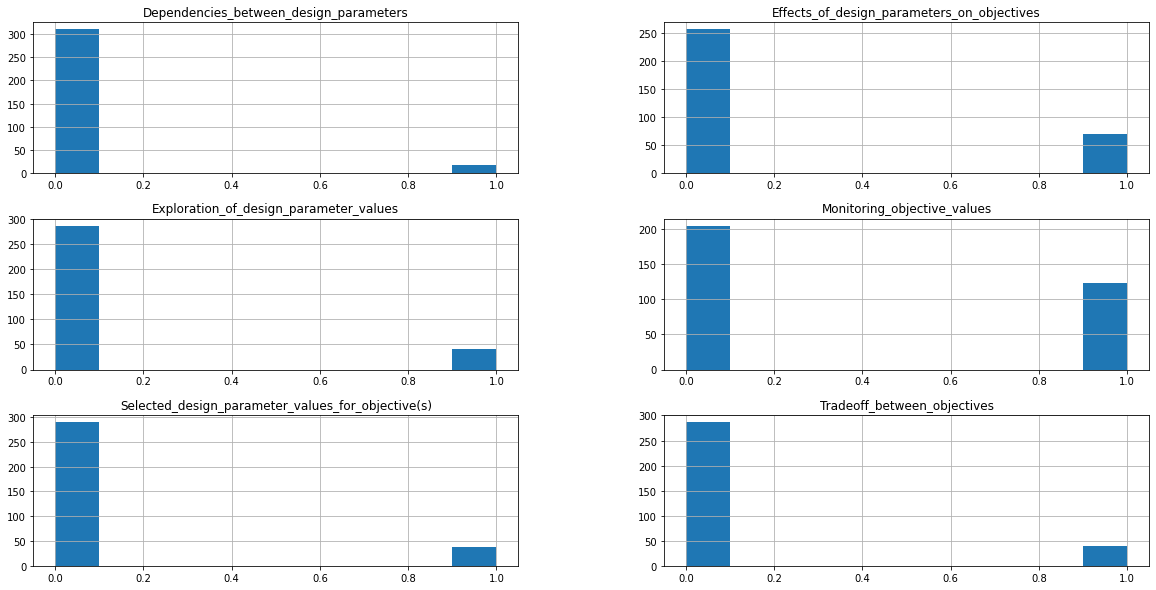

In [13]:
fig, ax = plt.subplots(figsize=(20, 10));
X_train[["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]].hist(ax=ax);

## Preprocess Data

In [14]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [15]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [16]:
train_text_list = X_train["full_text"].values
test_text_list = X_test["full_text"].values
valid_text_list = X_valid["full_text"].values
unlabeled_list = X_unlabeled["full_text"].values

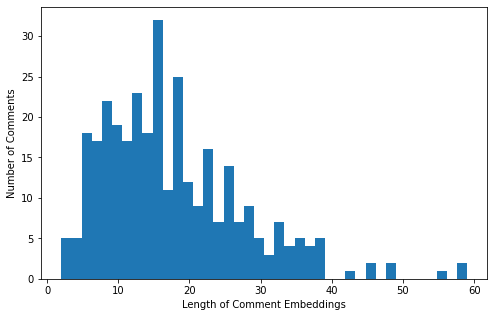

In [17]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

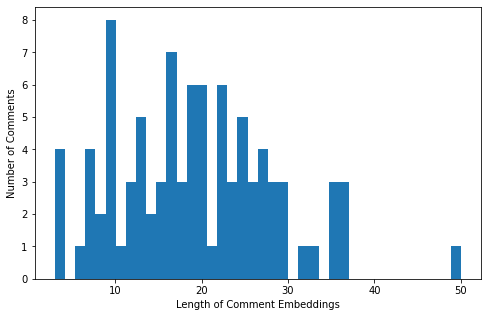

In [18]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

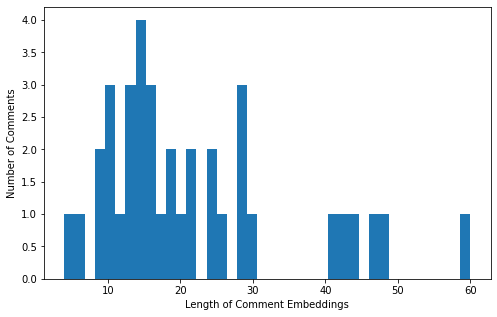

In [19]:
plot_sentence_embeddings_length(valid_text_list, tokenizer)

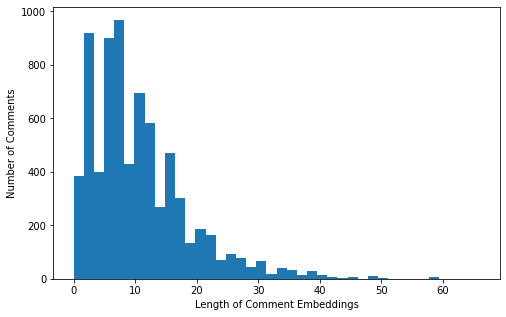

In [20]:
plot_sentence_embeddings_length(unlabeled_list, tokenizer)

In [21]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [22]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[ 160, 2624, 5523, ...,    0,    0,    0],
       [  18, 5926,  604, ...,    0,    0,    0],
       [  64,   44,  197, ...,    0,    0,    0],
       ...,
       [  80,   17,   88, ...,    0,    0,    0],
       [ 886,   61,   17, ...,    0,    0,    0],
       [  17, 3518,  112, ...,    0,    0,    0]])

In [23]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[ 2117,   290,    27, ...,     0,     0,     0],
       [   17,   150,   232, ...,     0,     0,     0],
       [  113,    27,    20, ...,     0,     0,     0],
       ...,
       [ 7693,    38,    24, ...,     0,     0,     0],
       [   17,   150,   232, ...,     0,     0,     0],
       [25159,  3350,  1168, ...,     0,     0,     0]])

In [24]:


# create input id tokens
valid_input_ids = tokenize_inputs(valid_text_list, tokenizer, num_embeddings=250)
valid_input_ids

array([[ 1115,  1021,    28, ...,     0,     0,     0],
       [  171,    17,  3518, ...,     0,     0,     0],
       [ 2395,   126,    18, ...,     0,     0,     0],
       ...,
       [  112,    44,   214, ...,     0,     0,     0],
       [   17,   150,   995, ...,     0,     0,     0],
       [   94, 10808,   811, ...,     0,     0,     0]])

In [25]:
# create input id tokens
unlabeled_input_ids = tokenize_inputs(unlabeled_list, tokenizer, num_embeddings=250)
unlabeled_input_ids

array([[   80,    47,  2712, ...,     0,     0,     0],
       [   47,    44,  3037, ...,     0,     0,     0],
       [   80,    47,  2712, ...,     0,     0,     0],
       ...,
       [  113,    75, 19387, ...,     0,     0,     0],
       [   81,    38,   421, ...,     0,     0,     0],
       [ 2153,    36,    24, ...,     0,     0,     0]])

In [26]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
train_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [27]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
test_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [28]:
# create attention masks
valid_attention_masks = create_attn_masks(valid_input_ids)
valid_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [29]:
# create attention masks
unlabeled_attention_masks = create_attn_masks(unlabeled_input_ids)
unlabeled_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [30]:
# add input ids and attention masks to the dataframe
X_train["features"] = train_input_ids.tolist()
X_train["masks"] = train_attention_masks

X_test["features"] = test_input_ids.tolist()
X_test["masks"] = test_attention_masks

X_valid["features"] = valid_input_ids.tolist()
X_valid["masks"] = valid_attention_masks

X_unlabeled["features"] = unlabeled_input_ids.tolist()
X_unlabeled["masks"] = unlabeled_attention_masks

In [31]:
X_train.head()

full_text  ...                                              masks
393  how widely appreciable is the value change gai...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
413  the median current television broadcast factor...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
214  Can you see if you increase your bore diamater...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
134          what s your component range of weights ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
358               what s in your human factorofsafety?  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 9 columns]

In [32]:
X_test.head()

full_text  ...                                              masks
373                                     mine area is 3  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
39         i think we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
340      what is of your global diameter at currently?  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
218  Hey looks like our factorofsafety went up  Wha...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
155  Range of weights was  1   49  to  4   81   My ...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 9 columns]

In [33]:
X_valid.head()

full_text  ...                                              masks
127                                   40  works for me  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
268     while ok seems like like not a huge difference  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
239  increasing back the value distribution of a be...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
151  I re-simulated with the others  updated values...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
229  all my factorofsafety values tested are in abo...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 9 columns]

In [34]:
X_unlabeled.head()

full_text  ...                                              masks
0              we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...
1  Have you broadcasted your most recent design ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
2              we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...
3                         looks like we re done ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4                                    seems like it  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 3 columns]

In [35]:
train_features = X_train["features"].values.tolist()
test_features = X_test["features"].values.tolist()
valid_features = X_valid["features"].values.tolist()

train_masks = X_train["masks"].values.tolist()
test_masks = X_test["masks"].values.tolist()
valid_masks = X_valid["masks"].values.tolist()

label_cols = ["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]
Y_train = X_train[label_cols].values.tolist()
Y_test = X_test[label_cols].values.tolist()
Y_valid = X_valid[label_cols].values.tolist()

In [36]:
del X_valid["Dependencies_between_design_parameters"]
del X_valid["Effects_of_design_parameters_on_objectives"]
del X_valid["Exploration_of_design_parameter_values"]
del X_valid["Monitoring_objective_values"]
del X_valid["Selected_design_parameter_values_for_objective(s)"]
del X_valid["Tradeoff_between_objectives"]
X_valid.head()

full_text  ...                                              masks
127                                   40  works for me  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
268     while ok seems like like not a huge difference  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
239  increasing back the value distribution of a be...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
151  I re-simulated with the others  updated values...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
229  all my factorofsafety values tested are in abo...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 3 columns]

In [37]:
del X_test["Dependencies_between_design_parameters"]
del X_test["Effects_of_design_parameters_on_objectives"]
del X_test["Exploration_of_design_parameter_values"]
del X_test["Monitoring_objective_values"]
del X_test["Selected_design_parameter_values_for_objective(s)"]
del X_test["Tradeoff_between_objectives"]
X_test.head()

full_text  ...                                              masks
373                                     mine area is 3  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
39         i think we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
340      what is of your global diameter at currently?  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
218  Hey looks like our factorofsafety went up  Wha...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
155  Range of weights was  1   49  to  4   81   My ...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 3 columns]

In [38]:
Y_train_targets = Y_train
Y_test_targets = Y_test
Y_valid_targets = Y_valid

## Create DataLoaders

In [39]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

train_features = torch.tensor(train_features)
test_features = torch.tensor(test_features)
valid_features = torch.tensor(valid_features)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
test_masks = torch.tensor(test_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [40]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_features, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

test_data = TensorDataset(test_features, test_masks, Y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,\
                              sampler=test_sampler,\
                              batch_size=batch_size)                          

validation_data = TensorDataset(valid_features, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## Training Data:

In [41]:
def train_model(model, num_epochs,\
                optimizer,\
                train_dataloader, valid_dataloader,\
                model_save_path,\
                train_loss_set=[], valid_loss_set = [],\
                lowest_eval_loss=None, start_epoch=0,\
                device="cpu"
                ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [42]:
torch.cuda.empty_cache()

In [43]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=6):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [45]:
num_epochs=4

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/xlnet_toxic_2.bin")
model, train_loss_set, test_loss_set =  train_model(model=model,\
                                                    num_epochs=num_epochs,\
                                                    optimizer=optimizer,\
                                                    train_dataloader=train_dataloader,\
                                                    valid_dataloader=test_dataloader,\
                                                    model_save_path=model_save_path,\
                                                    device="cuda")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.040553228297364824
Valid loss: 0.023709191576294277


Epoch:  25%|██▌       | 1/4 [00:15<00:45, 15.14s/it]

Saving model at epoch 0 with validation loss of 0.023709191576294277


Train loss: 0.023493139113125814
Valid loss: 0.019402119452538696


Epoch:  50%|█████     | 2/4 [00:30<00:30, 15.13s/it]

Saving model at epoch 1 with validation loss of 0.019402119452538696


Train loss: 0.016774688360341097
Valid loss: 0.015664526301881542


Epoch:  75%|███████▌  | 3/4 [00:45<00:15, 15.13s/it]

Saving model at epoch 2 with validation loss of 0.015664526301881542


Train loss: 0.011185344661776809


Epoch: 100%|██████████| 4/4 [00:58<00:00, 14.66s/it]

Valid loss: 0.017274093530748203




In [46]:
num_epochs=4

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/xlnet_toxic_2.bin")
model, train_loss_set, valid_loss_set =  train_model(model=model,\
                                                    num_epochs=num_epochs,\
                                                    optimizer=optimizer,\
                                                    train_dataloader=train_dataloader,\
                                                    valid_dataloader=validation_dataloader,\
                                                    model_save_path=model_save_path,\
                                                    device="cuda")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.006077883460356737
Valid loss: 0.014350920009451944


Epoch:  25%|██▌       | 1/4 [00:14<00:42, 14.19s/it]

Saving model at epoch 0 with validation loss of 0.014350920009451944


Train loss: 0.004628225698189907


Epoch:  50%|█████     | 2/4 [00:26<00:27, 13.65s/it]

Valid loss: 0.026794295053224306


Train loss: 0.004748630807350535


Epoch:  75%|███████▌  | 3/4 [00:38<00:13, 13.27s/it]

Valid loss: 0.016612708065155392


Train loss: 0.0023377247532795466


Epoch: 100%|██████████| 4/4 [00:51<00:00, 12.84s/it]

Valid loss: 0.022736352843207283




Text(0.5, 1.0, 'Loss vs Number of Epochs')

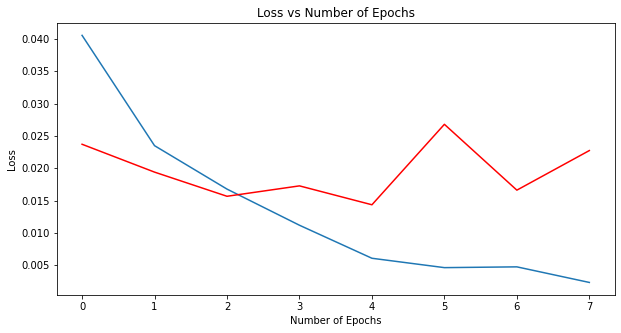

In [47]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(test_loss_set), 'r-', label="Test Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

Text(0.5, 1.0, 'Loss vs Number of Epochs')

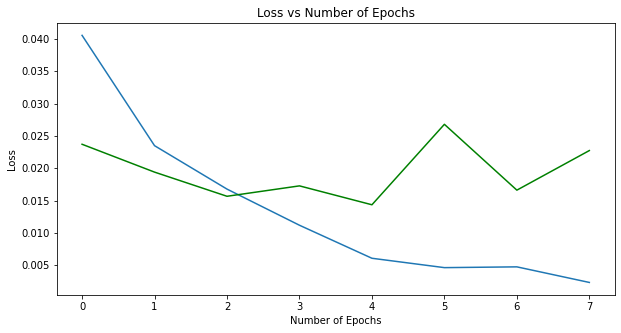

In [48]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Prediction on unlabeled dataset in supervised setting:

In [49]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [50]:
label_cols = ["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]
num_labels = len(label_cols)
pred_probs_valid = generate_predictions(model, X_valid, num_labels, device="cuda", batch_size=32)
pred_probs_test = generate_predictions(model, X_test, num_labels, device="cuda", batch_size=32)

In [51]:
X_valid["Dependencies_between_design_parameters"] = pred_probs_valid[:,0]
X_valid["Effects_of_design_parameters_on_objectives"] = pred_probs_valid[:,1]
X_valid["Exploration_of_design_parameter_values"] = pred_probs_valid[:,2]
X_valid["Monitoring_objective_values"] = pred_probs_valid[:,3]
X_valid["Selected_design_parameter_values_for_objective(s)"] = pred_probs_valid[:,4]
X_valid["Tradeoff_between_objectives"] = pred_probs_valid[:,5]

X_test["Dependencies_between_design_parameters"] = pred_probs_test[:,0]
X_test["Effects_of_design_parameters_on_objectives"] = pred_probs_test[:,1]
X_test["Exploration_of_design_parameter_values"] = pred_probs_test[:,2]
X_test["Monitoring_objective_values"] = pred_probs_test[:,3]
X_test["Selected_design_parameter_values_for_objective(s)"] = pred_probs_test[:,4]
X_test["Tradeoff_between_objectives"] = pred_probs_test[:,5]

In [52]:
Y_pred_valid = X_valid[label_cols].values.tolist()
Y_pred_test = X_test[label_cols].values.tolist()

In [53]:
Y_pred_valid=np.argmax(Y_pred_valid, axis=1)
Y_pred_test=np.argmax(Y_pred_test, axis=1)
Y_valid_targets=np.argmax(Y_valid_targets, axis=1)
Y_test_targets=np.argmax(Y_test_targets, axis=1)

In [54]:
print(classification_report(Y_valid_targets, Y_pred_valid, target_names=label_cols))

                                                   precision    recall  f1-score   support

           Dependencies_between_design_parameters       1.00      0.67      0.80         3
       Effects_of_design_parameters_on_objectives       0.71      0.77      0.74        13
           Exploration_of_design_parameter_values       0.88      0.78      0.82         9
                      Monitoring_objective_values       0.50      0.83      0.62         6
Selected_design_parameter_values_for_objective(s)       0.50      0.50      0.50         2
                      Tradeoff_between_objectives       1.00      0.25      0.40         4

                                         accuracy                           0.70        37
                                        macro avg       0.76      0.63      0.65        37
                                     weighted avg       0.76      0.70      0.70        37



In [55]:
print(classification_report(Y_test_targets, Y_pred_test, target_names=label_cols))

                                                   precision    recall  f1-score   support

           Dependencies_between_design_parameters       0.67      1.00      0.80         2
       Effects_of_design_parameters_on_objectives       0.86      0.83      0.84        23
           Exploration_of_design_parameter_values       0.50      0.57      0.53         7
                      Monitoring_objective_values       0.80      0.92      0.86        39
Selected_design_parameter_values_for_objective(s)       0.80      0.89      0.84         9
                      Tradeoff_between_objectives       1.00      0.33      0.50        12

                                         accuracy                           0.79        92
                                        macro avg       0.77      0.76      0.73        92
                                     weighted avg       0.82      0.79      0.78        92



## Self Learning:

Step 1: First, train a XL-Net classifier on the labeled training data.

Step 2: Next, use the classifier to predict labels for all unlabeled data, as well as probabilities for those predictions. In this case, I will only adopt ‘pseudo-labels’ for predictions with greater than 92% probability.

Step 3: Concatenate the ‘pseudo-labeled’ data with the labeled training data, and re-train the classifier on the concatenated data.

Step 4: Use trained classifier to make predictions for the labeled test data, and evaluate the classifier.

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.0023154045739253865
Valid loss: 0.021554300804500996


Epoch:  25%|██▌       | 1/4 [00:15<00:45, 15.09s/it]

Saving model at epoch 0 with validation loss of 0.021554300804500996


Train loss: 0.0010660096639140712
Valid loss: 0.021349653601646423


Epoch:  50%|█████     | 2/4 [00:30<00:30, 15.06s/it]

Saving model at epoch 1 with validation loss of 0.021349653601646423


Train loss: 0.0012154148093927424
Valid loss: 0.01944221661466619


Epoch:  75%|███████▌  | 3/4 [00:45<00:15, 15.04s/it]

Saving model at epoch 2 with validation loss of 0.01944221661466619


Train loss: 0.0005886309528481273


Epoch: 100%|██████████| 4/4 [00:58<00:00, 14.58s/it]

Valid loss: 0.02050931897500287


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0
7390 high-probability predictions added to training data.
394 unlabeled instances remaining.

Train loss: 0.0002996021850014658
Valid loss: 0.021633300444354183


Epoch:  25%|██▌       | 1/4 [00:14<00:44, 14.94s/it]

Saving model at epoch 0 with validation loss of 0.021633300444354183


Train loss: 0.0003844795838305983
Valid loss: 0.019638059579807778


Epoch:  50%|█████     | 2/4 [00:29<00:29, 14.94s/it]

Saving model at epoch 1 with validation loss of 0.019638059579807778


Train loss: 0.0018164379931082065


Epoch:  75%|███████▌  | 3/4 [00:43<00:14, 14.43s/it]

Valid loss: 0.024230907306722973


Train loss: 0.0018675355739116851
Valid loss: 0.018591054755708446


Epoch: 100%|██████████| 4/4 [00:58<00:00, 14.51s/it]

Saving model at epoch 3 with validation loss of 0.018591054755708446


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 1
295 high-probability predictions added to training data.
112 unlabeled instances remaining.

Train loss: 0.0008207652059209957
Valid loss: 0.015844968431021855


Epoch:  25%|██▌       | 1/4 [00:15<00:45, 15.08s/it]

Saving model at epoch 0 with validation loss of 0.015844968431021855


Train loss: 0.0002625453272878565


Epoch:  50%|█████     | 2/4 [00:28<00:29, 14.52s/it]

Valid loss: 0.016890112330894106


Train loss: 0.00019508463317928523


Epoch:  75%|███████▌  | 3/4 [00:41<00:14, 14.13s/it]

Valid loss: 0.017019789012999314


Train loss: 0.00017463546777190357


Epoch: 100%|██████████| 4/4 [00:54<00:00, 13.68s/it]

Valid loss: 0.016042940515984337


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 2
31 high-probability predictions added to training data.
83 unlabeled instances remaining.

Train loss: 0.0003123336902345012
Valid loss: 0.018709984830702128


Epoch:  25%|██▌       | 1/4 [00:15<00:45, 15.10s/it]

Saving model at epoch 0 with validation loss of 0.018709984830702128


Train loss: 0.00022374305131650082


Epoch:  50%|█████     | 2/4 [00:28<00:29, 14.53s/it]

Valid loss: 0.02043158905175717


Train loss: 0.00045019790559308603
Valid loss: 0.018587115666140682


Epoch:  75%|███████▌  | 3/4 [00:43<00:14, 14.64s/it]

Saving model at epoch 2 with validation loss of 0.018587115666140682


Train loss: 0.0002044773891472773


Epoch: 100%|██████████| 4/4 [00:56<00:00, 14.11s/it]

Valid loss: 0.020252877562914207


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 3
42 high-probability predictions added to training data.
41 unlabeled instances remaining.

Train loss: 0.00018179896181039527
Valid loss: 0.02038169858734245


Epoch:  25%|██▌       | 1/4 [00:15<00:46, 15.37s/it]

Saving model at epoch 0 with validation loss of 0.02038169858734245


Train loss: 0.00016485813708135016


Epoch:  50%|█████     | 2/4 [00:28<00:29, 14.73s/it]

Valid loss: 0.022654624007966206


Train loss: 0.00044522110577220587


Epoch:  75%|███████▌  | 3/4 [00:41<00:14, 14.27s/it]

Valid loss: 0.02234057041451983


Train loss: 0.0005105304421189658


Epoch: 100%|██████████| 4/4 [00:54<00:00, 13.75s/it]

Valid loss: 0.021939304879988016


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 4
3 high-probability predictions added to training data.
38 unlabeled instances remaining.

Train loss: 0.00019868231603093603
Valid loss: 0.021553179282067424


Epoch:  25%|██▌       | 1/4 [00:14<00:44, 14.90s/it]

Saving model at epoch 0 with validation loss of 0.021553179282067424


Train loss: 0.00019668988790131668


Epoch:  50%|█████     | 2/4 [00:28<00:28, 14.40s/it]

Valid loss: 0.02185526989326362


Train loss: 0.00017319779119790576


Epoch:  75%|███████▌  | 3/4 [00:41<00:14, 14.04s/it]

Valid loss: 0.02271719770910947


Train loss: 0.00015427296994476855


Epoch: 100%|██████████| 4/4 [00:54<00:00, 13.63s/it]

Valid loss: 0.02239694361291502


Now predicting labels for unlabeled data...


Iteration 5
0 high-probability predictions added to training data.
38 unlabeled instances remaining.



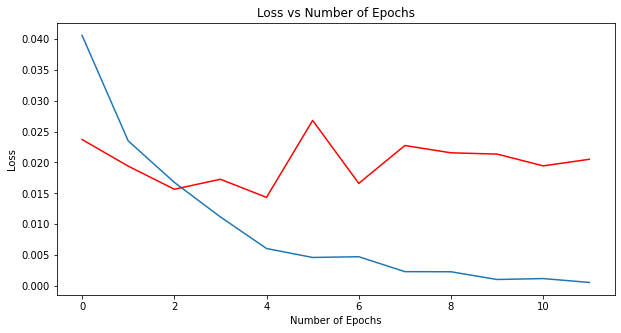

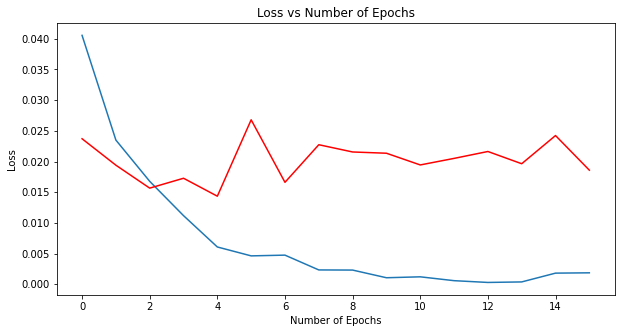

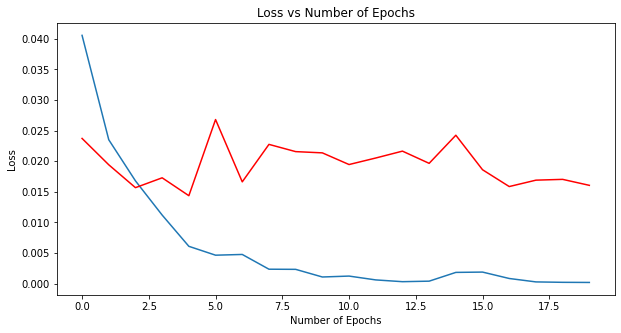

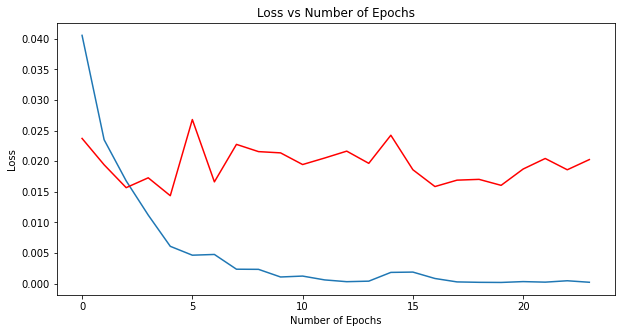

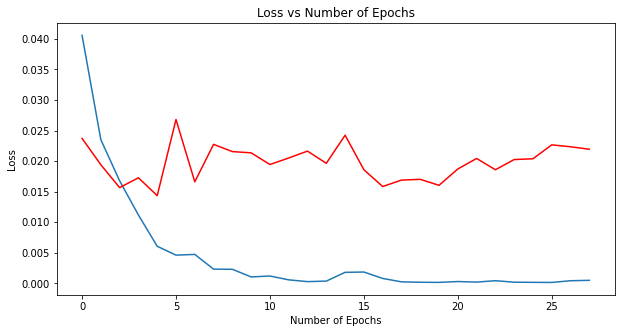

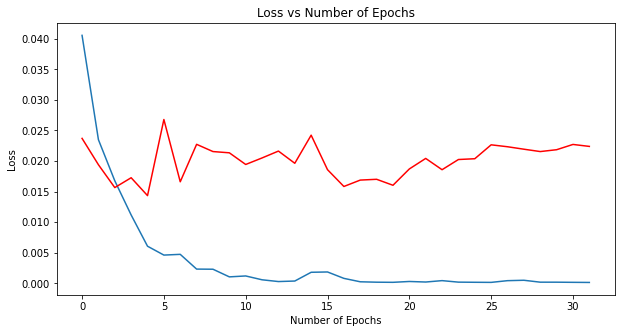

In [56]:
# Initiate iteration counter
iterations = 0
label_cols = ["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]
num_labels = len(label_cols)

# Containers to hold # of pseudo-labels
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    num_epochs=4

    cwd = os.getcwd()
    model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/xlnet_toxic_2.bin")
    model, train_loss_set, test_loss_set =  train_model(model=model,\
                                                        num_epochs=num_epochs,\
                                                        optimizer=optimizer,\
                                                        train_dataloader=train_dataloader,\
                                                        valid_dataloader=test_dataloader,\
                                                        model_save_path=model_save_path,\
                                                        device="cuda")
    # Plot loss
    num_epochs = np.arange(len(train_loss_set))

    fig, ax = plt.subplots(figsize=(10, 5));
    ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
    ax.plot(num_epochs, np.array(test_loss_set), 'r-', label="Test Loss")
    ax.set_xlabel("Number of Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Number of Epochs")

    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")
    pred_probs = generate_predictions(model, X_unlabeled, num_labels, device="cuda", batch_size=32)
    X_unlabeled["Dependencies_between_design_parameters"] = pred_probs[:,0]
    X_unlabeled["Effects_of_design_parameters_on_objectives"] = pred_probs[:,1]
    X_unlabeled["Exploration_of_design_parameter_values"] = pred_probs[:,2]
    X_unlabeled["Monitoring_objective_values"] = pred_probs[:,3]
    X_unlabeled["Selected_design_parameter_values_for_objective(s)"] = pred_probs[:,4]
    X_unlabeled["Tradeoff_between_objectives"] = pred_probs[:,5]


    # Calculate and print iteration 
    print(f"Iteration {iterations}")

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['Dependencies_between_design_parameters'] = X_unlabeled["Dependencies_between_design_parameters"]
    df_pred_prob['Effects_of_design_parameters_on_objectives'] = X_unlabeled["Effects_of_design_parameters_on_objectives"]
    df_pred_prob['Exploration_of_design_parameter_values'] = X_unlabeled["Exploration_of_design_parameter_values"]
    df_pred_prob['Monitoring_objective_values'] = X_unlabeled["Monitoring_objective_values"]
    df_pred_prob['Selected_design_parameter_values_for_objective(s)'] = X_unlabeled["Selected_design_parameter_values_for_objective(s)"]
    df_pred_prob['Tradeoff_between_objectives'] = X_unlabeled["Tradeoff_between_objectives"]
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 42% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['Dependencies_between_design_parameters'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Effects_of_design_parameters_on_objectives'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Exploration_of_design_parameter_values'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Monitoring_objective_values'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Selected_design_parameter_values_for_objective(s)'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Tradeoff_between_objectives'] > 0.42],], axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

In [57]:
len(X_train), len(X_unlabeled)

(8088, 38)

In [58]:
X_train.head(2)

full_text  ...                                              masks
393  how widely appreciable is the value change gai...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
413  the median current television broadcast factor...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[2 rows x 9 columns]

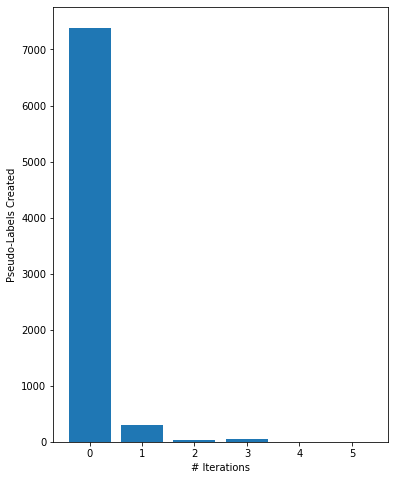

In [59]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, ax = plt.subplots(figsize=(6,8))
ax.bar(x=range(iterations), height=pseudo_labels)
ax.set_ylabel('Pseudo-Labels Created')
ax.set_xlabel('# Iterations');

## Final Dataset Output | Post-Processing:

In [60]:
X_train.drop(['features', 'masks'], axis = 1, inplace= True)

In [63]:
X_train_text = X_train['full_text']
X_train.drop(['full_text'], axis = 1, inplace= True)

In [65]:
X_train['max_value'] = ''
X_train['max_value'] = X_train.max_value

In [68]:
label = []
for j in range(len(X_train)):
  for i in X_train.columns:
    if X_train.iloc[j][i] == X_train.iloc[j]['max_value']:
      label.append(i)
      break

In [69]:
X_train['label'] = label
X_train['full_text'] = X_train_text

In [70]:
X_train.drop(["max_value", "Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"], axis = 1, inplace= True)
X_train.reset_index(inplace=True)
X_train.drop(['index'], axis = 1, inplace= True)

In [84]:
X_train.to_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/final_output_Q2.csv', index = False, sep = ',')